### Import

In [1]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

# Files
from vehicle import *
from simulate import *
from mpc import *
from global_path_planning import *
from obstacles import *


### Simulation Input Parameters

In [2]:
#### MPC Properties
dt = 0.1                  # Time step [s]
N = 15                # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 20, 0, 60, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
x_init = [10, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]          # Initial State: [x, y, z, x_dot, y_dot, z_dot]
x_target_last = [10, 48, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0]      # Target State: [x, y, z, x_dot, y_dot, z_dot]
T = 20                             # Simulation time [s]


# Speed limit
speed_limit = 10

# Roll and Pitch limit
angle_limit = 90

# Acceleration limit
acc_limit_x = 15
acc_limit_y = 15
acc_limit_z = 15

       # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
vel_constraints = [-speed_limit, speed_limit, -speed_limit, speed_limit, -speed_limit, speed_limit]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max, z_min, z_max]
ang_constraints = [-angle_limit, angle_limit, -angle_limit, angle_limit, -360, 360]         # Angular Velocity Constraints [rad/s]:  [x_min, x_max, y_min, y_max, z_min, z_max]
acc_constraints = [-acc_limit_x, acc_limit_x, -acc_limit_y, acc_limit_y, -acc_limit_z, acc_limit_z]  
max_rad_per_s = 4000

#### Obstacles
static_cost = 5
dynamic_cost = 15

#### Waypoint Radius Threshold
waypoint_radius = 7


In [3]:
#### Obstacle Definition and Initialization

## Define Obstacles
# V_obstacles = [[10, 20, 4], [18, 30, 3]]
V_obstacles = [[10, 30, 2], [17, 23, 3], [7, 20, 4], [14, 37, 3], [1, 28, 4]]
#V_move_obstacles = [[17, 30, -0.1, 0, 1.5], [5, 50, 0, -0.1, 2], [0, 42, 0.1, 0, 3]]
V_move_obstacles = []
H_obstacles = [[10, 10, 3]]         # [center_y, center_z, radius]
H_move_obstacles = []  # [center_y, center_z, vel_y, vel_z, radius]

## Initialize Obstacles
obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

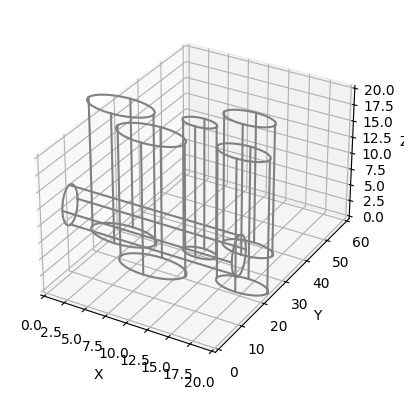

IntProgress(value=0, max=500)

Goal found


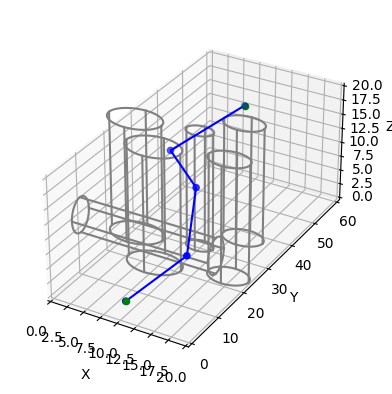

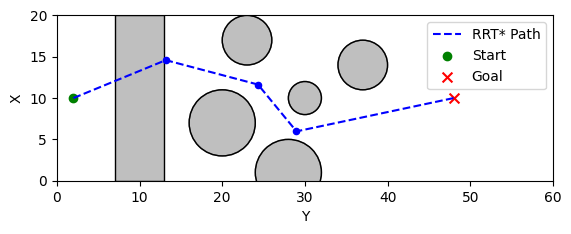

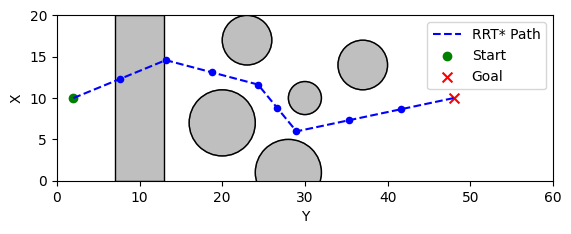

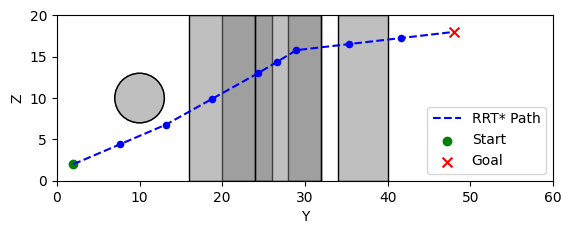

In [4]:
# Create Static World
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles, obstacle_margin=1)
World.plot3d()

# Run RRT* to find a path
path_rrt = rrt_star(World, x_init[:3], x_target_last[:3], radius=25, max_iter=500)
World.plot3d(path_rrt)
World.plot2d_xy(path_rrt)

path_rrt = path_rrt.get_subdivided_path(15)
World.plot2d_xy(path_rrt)
World.plot2d_yz(path_rrt)


In [5]:
# %%capture
# Setup Controller and Simulate
vehicle = Quadrotor(dt)
controller = lambda x_init, current_wp, last_input, last_plan : mpc_control(vehicle, N, x_init, current_wp, pos_constraints, vel_constraints, acc_constraints, ang_constraints, max_rad_per_s, last_plan, obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, x_target_last, N, controller, World, path_rrt, waypoint_radius, num_states=12, num_inputs=4)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.75ms ( 73.08us)        24
       nlp_g  |        0 (       0)   4.87ms (202.92us)        24
  nlp_grad_f  |        0 (       0)   2.67ms (106.72us)        25
  nlp_hess_l  |  72.00ms (  3.13ms)  65.81ms (  2.86ms)        23
   nlp_jac_g  |  67.00ms (  2.68ms)  35.52ms (  1.42ms)        25
       total  | 212.00ms (212.00ms) 201.32ms (201.32ms)         1
Optimal cost: 373.19396742164434
Progress: 0/200
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 

In [ ]:
## Plot Simulation
obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

def update(frame):
    global ax
    # Clear previous frame
    ax.cla()

    # Plot Path for current state
    ax.scatter(plans[0][:, frame], plans[1][:, frame], plans[2][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    ax.scatter(target_state[0][frame], target_state[1][frame], target_state[2][frame], s=40, color='b', label = "Target Point")

    ax.scatter(states[0][frame], states[1][frame], states[2][frame], s=40, color='red', label = "Drone")
    
    World.update(dt)

    # Plot Environment
    World.plot3d_ax(ax)

    ax.legend()
    ax.set_title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame




# Create the animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)
# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())


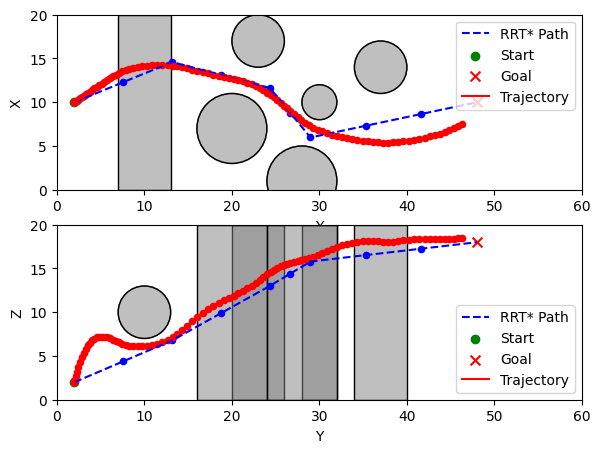

In [6]:
#plot the path with 2 subplots

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

World.plot2d_xy_ax(ax1, path_rrt, states)
World.plot2d_yz_ax(ax2, path_rrt, states)
                   

In [ ]:
#Evaluation metrics
from evaluation_metrics import *

print("states3-6 shape",states[3:6].T.shape)
# 1. Trajectory Smoothness
plot_trajectory_smoothness(velocities=states[3:6].T,
                           orientation_rates=states[6:9].T,
                           num_timesteps=len(timesteps),
                           duration_sec=T,
                           dt=dt)
# 2. Control Effort
print("inputs T shape:",inputs.T.shape)
print("inputs0",inputs.T[0])
plot_control_effort(control_inputs=inputs.T,
                    duration_sec=T,
                    num_timesteps =len(timesteps))